In [1]:
import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # or any {‘0’, ‘1’, ‘2’}
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["TF_CPP_VMODULE"]="gpu_process_state=10,gpu_cudamallocasync_allocator=10"
import tensorflow_probability as tfp
#from tf_keras import layers, Model, models
from tensorflow.keras import layers, Model, models, metrics, optimizers
#from tensorflow import keras
import keras
import tensorflow_datasets as tfds2
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import itertools
import gc
import os
import json
import inspect
import shutil
tf.random.set_seed(1)

2024-11-29 21:20:28.863773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732911628.908865   43399 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732911628.915952   43399 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 21:20:28.947430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.0
Num GPUs Available:  1


/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading + processing

In [2]:
parental_geno_data = pd.read_csv("./data/parent_genos_ordered.csv")
child_geno_data = pd.read_csv("./data/all_child_genos_ordered.csv")

# Get population per sample, split populations into oop and train
pop_per_sample = child_geno_data["pop"].to_numpy()
test_pops = np.random.choice(np.unique(pop_per_sample), 6)
train_pops_idx = ~np.isin(pop_per_sample, test_pops)
test_geno_pops = pop_per_sample[np.isin(pop_per_sample, test_pops)]

In [3]:
all_geno_combs = list(itertools.product(["A", "T", "G", "C"], ["A", "T", "G", "C"])) + [("-", "-")]
all_geno_combs = np.unique(["".join(np.sort(cur_genos)) for cur_genos in all_geno_combs])

In [4]:
p1_ids = child_geno_data['p1_id'].to_numpy()
p2_ids = child_geno_data['p2_id'].to_numpy()
p_pop = child_geno_data['pop'].to_numpy()

# Parent 1 is technically always maize B73
# -> shuffle parent ids so model isnt fed same p1 input across all samples
p_genos_ids = np.stack([p1_ids, p2_ids], axis = 1)
[np.random.shuffle(cur_sub) for cur_sub in p_genos_ids]

# Extract parental genos from pandas df, split to train and OOP
parental_geno_np = parental_geno_data.iloc[:, 1:].to_numpy()
p1_genos_np = np.stack([parental_geno_np[cur_p-1, :-1] for cur_p in p_genos_ids[:, 0]], axis =0 )
p2_genos_np = np.stack([parental_geno_np[cur_p-1, :-1] for cur_p in p_genos_ids[:, 1]], axis =0 )
p1_genos_np_train = p1_genos_np[train_pops_idx, :]
p1_genos_np_test = p1_genos_np[~train_pops_idx, :]
p2_genos_np_train = p2_genos_np[train_pops_idx, :]
p2_genos_np_test = p2_genos_np[~train_pops_idx, :]
p_pop_test = p_pop[~train_pops_idx]
p_pop_train = p_pop[train_pops_idx]

# Split child geno types into train + (in population) evaluation error and OOP
# IP data == eval, OOP == test
child_geno_np_train_eval = child_geno_data.iloc[train_pops_idx, 2:-2].to_numpy()
child_geno_np_test = child_geno_data.iloc[~train_pops_idx, 2:-2].to_numpy()
child_geno_np = child_geno_data.iloc[:, 2:-2].to_numpy()

In [5]:
# Construct np arrays from individual arrays, split train+eval array into individual
# train and eval arrays
# Technically this could be achieved way simpler by splitting a tf dataset, but
# since the genotype arrays dont contain the population id this is the only way i found
# to track them
 
full_sample_np_train_eval = np.stack([child_geno_np_train_eval,
    p1_genos_np_train,
    p2_genos_np_train],
    axis = 1)
eval_samples = np.random.choice(range(full_sample_np_train_eval.shape[0]),
                                size = 1000, replace = False)
full_sample_np_train = np.delete(full_sample_np_train_eval, eval_samples, axis = 0)
child_geno_np_eval = child_geno_np_train_eval[eval_samples, ...]
child_geno_np_train = np.delete(child_geno_np_train_eval, eval_samples, axis = 0)

train_pops = np.delete(p_pop_train, eval_samples)
eval_pops = p_pop_train[eval_samples]
full_sample_np_eval = full_sample_np_train_eval[eval_samples, ...]

full_sample_np_test = np.stack([child_geno_np_test,
    p1_genos_np_test,
    p2_genos_np_test],
    axis = 1)
full_sample_np = np.stack([child_geno_np,
    p1_genos_np,
    p2_genos_np],
    axis = 1)

In [6]:
# Convert data into one hot encodings and stack to tensors

child_geno_one_hot_train = [np.float16(child_geno_np_train == cur_class) for cur_class in all_geno_combs]
child_geno_tensor_train = tf.stack(child_geno_one_hot_train, axis = -1)
geno_np_layers_train = [np.float16(full_sample_np_train == cur_class) for cur_class in all_geno_combs]
geno_tensor_train = tf.stack(geno_np_layers_train, axis = -1)

child_geno_one_hot_eval = [np.float16(child_geno_np_eval == cur_class) for cur_class in all_geno_combs]
child_geno_tensor_eval = tf.stack(child_geno_one_hot_eval, axis = -1)
geno_np_layers_eval = [np.float16(full_sample_np_eval == cur_class) for cur_class in all_geno_combs]
geno_tensor_eval = tf.stack(geno_np_layers_eval, axis = -1)

child_geno_one_hot_test = [np.float16(child_geno_np_test == cur_class) for cur_class in all_geno_combs]
child_geno_tensor_test = tf.stack(child_geno_one_hot_test, axis = -1)
geno_np_layers_test = [np.float16(full_sample_np_test == cur_class) for cur_class in all_geno_combs]
geno_tensor_test = tf.stack(geno_np_layers_test, axis = -1)

child_geno_one_hot = [np.float16(child_geno_np == cur_class) for cur_class in all_geno_combs]
child_geno_tensor = tf.stack(child_geno_one_hot, axis = -1)
geno_np_layers = [np.float16(full_sample_np == cur_class) for cur_class in all_geno_combs]
geno_tensor = tf.stack(geno_np_layers, axis = -1)


I0000 00:00:1732911638.034644   43399 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1732911638.159556   43399 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


In [7]:
# train_dataset -> actual training
# eval -> test dataset without seeing children, shared parents with train_dataset (IP)
# test_dataset -> test dataset without seeing children + parents (OOP)

full_dataset = tf.data.Dataset.from_tensor_slices((geno_tensor_train, child_geno_tensor_train))
full_dataset = full_dataset.shuffle(buffer_size=int(1e6))
train_dataset = full_dataset
train_dataset = train_dataset.batch(256, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((geno_tensor_test, child_geno_tensor_test))
test_dataset = test_dataset.shuffle(buffer_size=int(1e6))
test_dataset = test_dataset.batch(geno_tensor_test.shape[0], drop_remainder=True)

## Model definition

In [19]:
# Moved defintions to separate python scripts
execfile("cur_helpers.py")
execfile("cur_encoder.py")
execfile("cur_decoder.py")
execfile("cur_autoencoder.py")
cur_base_dir = "./data/var_autoencoder/deeper_enc/"
if not os.path.isdir(cur_base_dir):
    os.mkdir(cur_base_dir)

## Grid testing
* Deprecated, need to rerun once satisfying VAE structure found
* Test hyperparamters in grid like fashion

In [ ]:

def fit_per_para(encoder_w, decoder_d, epochs = 100):
    print("###########################################")
    print(f"current encoder width: {encoder_w}")
    print(f"current decoder depth: {decoder_d}")
    true_classes = np.argmax(geno_tensor, axis = 1).reshape((-1))

    # used for focal loss
    inv_class_frequencies = 1 - ((np.unique(true_classes, return_counts=True)[1] / len(true_classes)))

    focal_loss = tf.keras.losses.CategoricalCrossentropy(axis = 1,
                                                          from_logits=False)

    focal_optimizer = optimizers.Lion(learning_rate=1e-4)
    model = autoencoder(100, encoder_width=encoder_w, decoder_depth=decoder_d)
    model.compile(optimizer=focal_optimizer, loss = focal_loss, run_eagerly=False,
                      metrics=[metrics.CategoricalAccuracy()])
    model_train_loss = model.fit(train_dataset, epochs=epochs, shuffle=True,
                                 validation_data = test_dataset)
    true_classes = np.argmax(test_labels, axis = 1).reshape((-1))
    pred_classes = np.argmax(model(test_labels), axis = 1).reshape((-1))
    class_acc = [np.sum((pred_classes == true_classes) & (pred_classes == cur_class))/
           np.sum(true_classes == cur_class) for cur_class in np.unique(true_classes)]
    print(class_acc)
    print(pd.crosstab(pd.Series(pred_classes, name="Predicted"), pd.Series(true_classes, name="Actual")))
    out = [class_acc, model_train_loss]
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()

    return out

In [ ]:
paras = list(itertools.product(list(range(5,0,-1)),list(range(5,0, -1))))

In [ ]:
res_per_para = [fit_per_para(cur_paras[0], cur_paras[1], epochs = 100) for cur_paras in paras]

###########################################
encoder_w: 5
decoder_d: 5
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - categorical_accuracy: 0.0014 - loss: 1.1271 - val_categorical_accuracy: 0.0020 - val_loss: 1.0366
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0020 - loss: 1.0030 - val_categorical_accuracy: 6.5104e-04 - val_loss: 0.9019
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.0025 - loss: 0.8578 - val_categorical_accuracy: 0.0290 - val_loss: 0.7626
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.0299 - loss: 0.7604 - val_categorical_accuracy: 0.0280 - val_loss: 0.7459
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.0287 - loss: 0.7447 - val_categorical_accuracy: 0.0238 - val_loss: 0.7372
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0256 - loss: 0.7354 - val_categorical_accuracy: 0.0280 - val_loss: 0.7304
Epoch 7/200


In [ ]:
res_dict = {str(paras[cur_para_id]):[res_per_para[cur_para_id][0], res_per_para[cur_para_id][1].history] for cur_para_id in range(len(paras))}
res_out = open(cur_base_dir + "grid_test.txt", "w")
res_out.write(json.dumps(res_dict))
res_out.close()

In [ ]:
res_deep_encoder_thining = json.loads(open(cur_base_dir + "grid_test.txt").read())
dt_keys = list(res_deep_encoder_thining.keys())
dt_acc = [res_deep_encoder_thining[cur_dict][0] for cur_dict in dt_keys]
dt_train = [res_deep_encoder_thining[cur_dict][1]["loss"] for cur_dict in dt_keys]
dt_val = [res_deep_encoder_thining[cur_dict][1]["val_loss"] for cur_dict in dt_keys]

In [ ]:
dt_acc_df = pd.DataFrame(np.array(dt_acc))
dt_acc_df["fit"] = dt_keys

dt_train_df = pd.DataFrame(np.array(dt_train))
dt_train_df["fit"] = dt_keys

dt_train_df["loss_type"] = "train"
dt_val_df = pd.DataFrame(np.array(dt_val))
dt_val_df["fit"] = dt_keys
dt_val_df["loss_type"] = "test"
dt_train_df = pd.concat((dt_train_df, dt_val_df))

In [ ]:
dt_train_df.to_csv(cur_base_dir + "model_5_train.csv", sep=",")
dt_acc_df.to_csv(cur_base_dir + "model_5_acc.csv", sep=",")

## Individual Models

In [20]:
focal_optimizer = optimizers.Adam(learning_rate=1e-3)#, use_ema = True)# ema_overwrite_frequency = int(1e3))
focal_model = autoencoder(100, 5, 5)
focal_model.compile(optimizer=focal_optimizer, run_eagerly = False)

Epoch 1/100


/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2024-11-29 21:47:32.364834: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : 

10/10 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - 0_acc: 0.1149 - 10_acc: 0.4603 - 1_acc: 0.5028 - 2_acc: 0.0035 - 3_acc: 0.0080 - 4_acc: 0.0021 - 5_acc: 0.5052 - 6_acc: 0.0021 - 7_acc: 0.0093 - 8_acc: 0.4832 - 9_acc: 0.0016 - cat_acc: 0.4739 - climbing: 0.0000e+00 - elbo: 6.4986 - kl_loss: 1.8580 - reconstruction_loss: 4.6407 - trainable_vars_tracker: 0.0000e+00 - val_0_acc: 0.0000e+00 - val_10_acc: 0.4917 - val_1_acc: 0.4267 - val_2_acc: 0.0000e+00 - val_3_acc: 0.0000e+00 - val_4_acc: 0.0000e+00 - val_5_acc: 0.4999 - val_6_acc: 0.0000e+00 - val_7_acc: 0.0000e+00 - val_8_acc: 0.4775 - val_9_acc: 0.0000e+00 - val_cat_acc: 0.4707 - val_climbing: 1.0000 - val_elbo: 6.3447 - val_kl_loss: 6.2592 - val_reconstruction_loss: 0.0855 - val_trainable_vars_tracker: 174.0000
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 995ms/step - 0_acc: 0.0000e+00 - 10_acc: 0.5890 - 1_acc: 0.5757 - 2_acc: 0.0000e+00 - 3_acc: 0.0000e+00 - 4_acc: 0.0000e+00 - 5_acc: 0.5797 - 6_acc: 0.0000e+00 - 7_acc: 0.0000e+00 - 8_acc: 0.

cur_helpers.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit the suptitle and legend
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


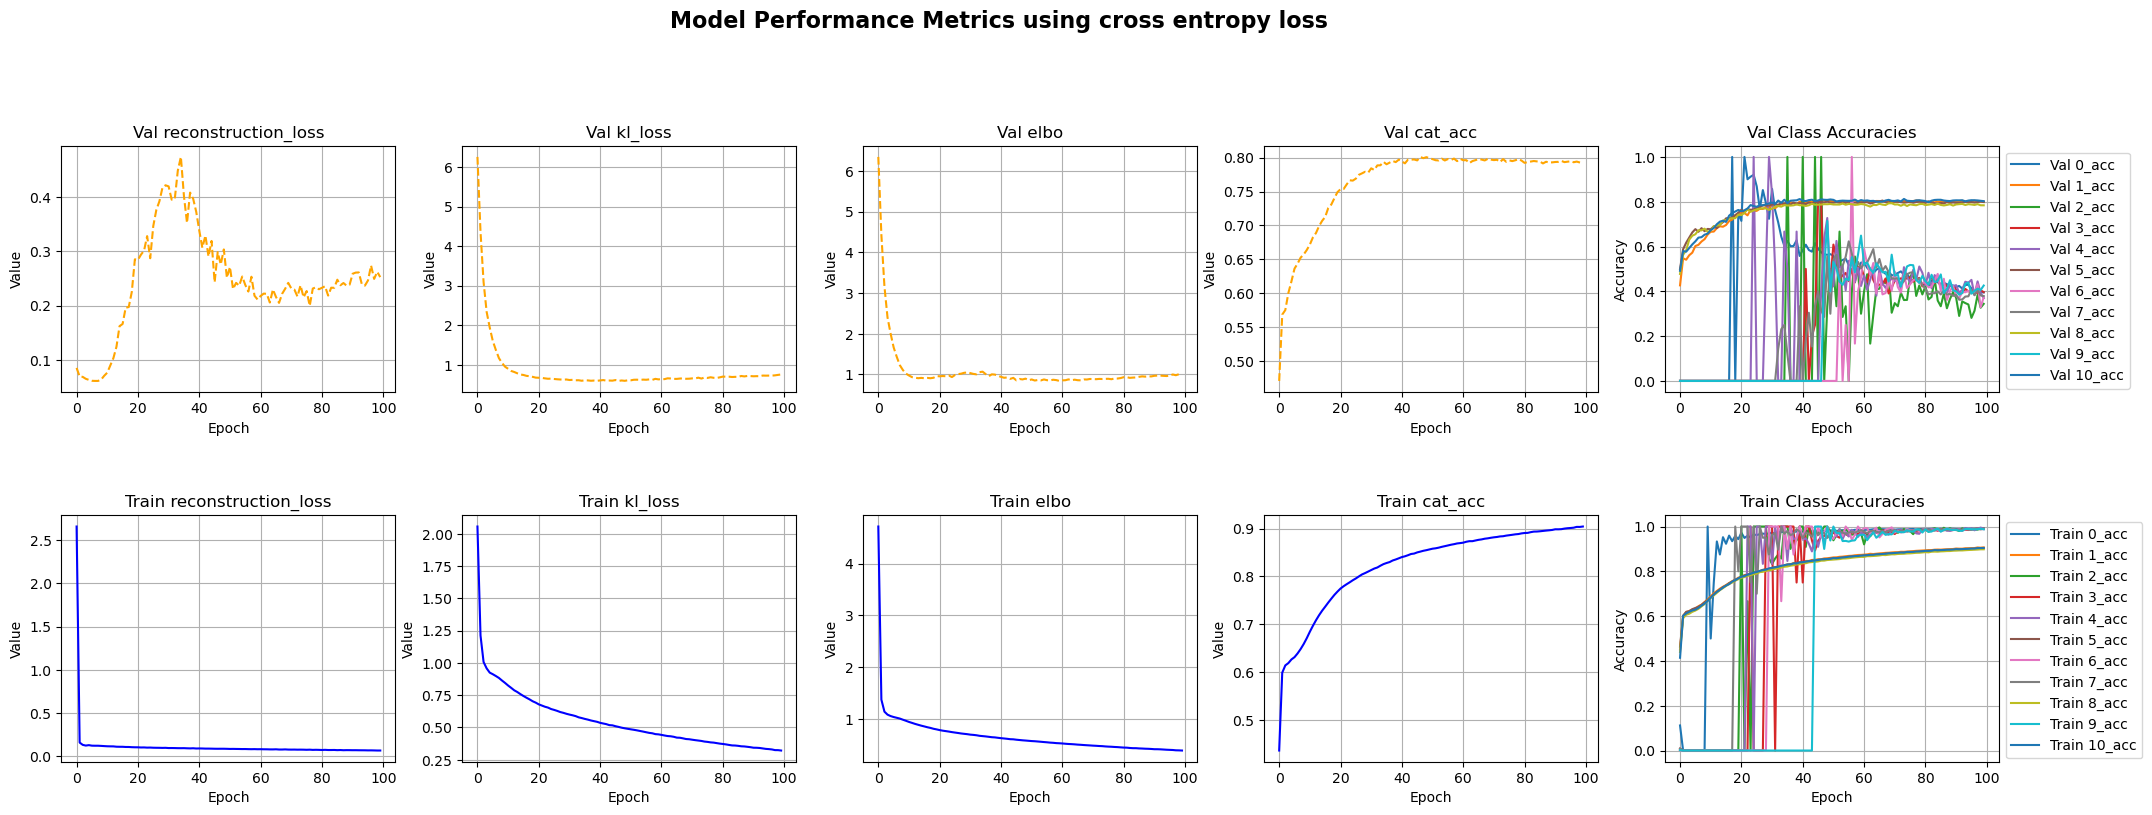

In [21]:
train_stats = train_and_get_results(focal_model, epochs = 100,
    base_dir = cur_base_dir, write_to_disk = True)

In [ ]:
test_pred = focal_model(geno_tensor_train)
test_pred = np.argmax(test_pred, axis = -1)
test_pred_df = pd.DataFrame(test_pred)
test_pred_df["d_type"] = "pred"
truth_df = pd.DataFrame(np.argmax(geno_tensor_train[:, 0, :], axis = -1))
truth_df["d_type"] = "truth"
full_train_df = pd.concat([test_pred_df, truth_df], axis = 0)
full_train_df.to_csv(cur_base_dir + "train_pop_pred.csv")

In [ ]:
test_pred = focal_model(geno_tensor_test)
test_pred = np.argmax(test_pred, axis = -1)
test_pred_df = pd.DataFrame(test_pred)
test_pred_df["d_type"] = "pred"
truth_df = pd.DataFrame(np.argmax(geno_tensor_test[:, 0, :], axis = -1))
truth_df["d_type"] = "truth"
full_test_df = pd.concat([test_pred_df, truth_df], axis = 0)
full_test_df.to_csv(cur_base_dir + "new_pop_pred.csv")

In [19]:
# Load stored model
execfile("./data/var_autoencoder/with_unseen_children_vanilla_vae/helpers.py")
execfile("./data/var_autoencoder/with_unseen_children_vanilla_vae/encoder.py")
execfile("./data/var_autoencoder/with_unseen_children_vanilla_vae/decoder.py")
execfile("./data/var_autoencoder/with_unseen_children_vanilla_vae/autoencoder.py")

loaded_model = keras.models.load_model(
    "./data/var_autoencoder/with_unseen_children_vanilla_vae/with_unseen_children_vanilla_vae.keras",
    custom_objects = {"encoder" : encoder, "decoder" : decoder, "autoencoder" : autoencoder,
        "elbo_loss" : elbo_loss, "rec_loss_fn" : rec_loss_fn, "feature_drop_layer": feature_drop_layer}
)
cur_model = loaded_model

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 270 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
# Store encoded data for embedding analysis

encoded_data = cur_model.encoder(geno_tensor)
encoded_data_df = pd.DataFrame(encoded_data[0].numpy())
child_geno_data.iloc[train_pops_idx, 2:-2].to_numpy()
encoded_data_df["individual"] = child_geno_data["individual"].to_numpy()
encoded_data_df["pop"] = child_geno_data["pop"].to_numpy()
encoded_data_df["p1_id"] = child_geno_data["p1_id"].to_numpy()
encoded_data_df["p2_id"] = child_geno_data["p2_id"].to_numpy()
# encoded_data_df.to_csv("./data/var_autoencoder/with_unseen_children_vanilla_vae/encoded_mean_all_samples.csv", index = False)
#
encoded_data_df = pd.DataFrame(encoded_data[1].numpy())
encoded_data_df["individual"] = child_geno_data["individual"].to_numpy()
encoded_data_df["pop"] = child_geno_data["pop"].to_numpy()
encoded_data_df["p1_id"] = child_geno_data["p1_id"].to_numpy()
encoded_data_df["p2_id"] = child_geno_data["p2_id"].to_numpy()
# encoded_data_df.to_csv("./data/var_autoencoder/with_unseen_children_vanilla_vae/encoded_logvar_all_samples.csv", index = False)

In [ ]:
decoded_data = cur_model.decoder(geno_tensor[:, 1:3, ...],
                                   cur_model.sample_z(encoded_data[0], encoded_data[1]))

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
decoded_data_df = pd.DataFrame(np.argmax(decoded_data.numpy(), axis = -1))
decoded_data_df.replace(list(range(len(all_geno_combs))), all_geno_combs, inplace=True)
decoded_data_df["individual"] = child_geno_data["individual"]
decoded_data_df["pop"] = child_geno_data["pop"]
decoded_data_df.to_csv("decoded_genos_all_samples.csv")

In [22]:
true_classes = np.argmax(geno_tensor_test[:, 0, ...], axis = -1)
pred_classes = np.argmax(cur_model(geno_tensor_test), axis = -1)
marker_acc = np.sum(pred_classes == true_classes, axis = 1)/pred_classes.shape[1]
marker_var = np.var(pred_classes == true_classes, axis = 1)/pred_classes.shape[1]

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'autoencoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [23]:
y = np.vstack([marker_acc[np.argsort(marker_acc)], marker_var[np.argsort(marker_acc)]])
x = range(y.shape[1])

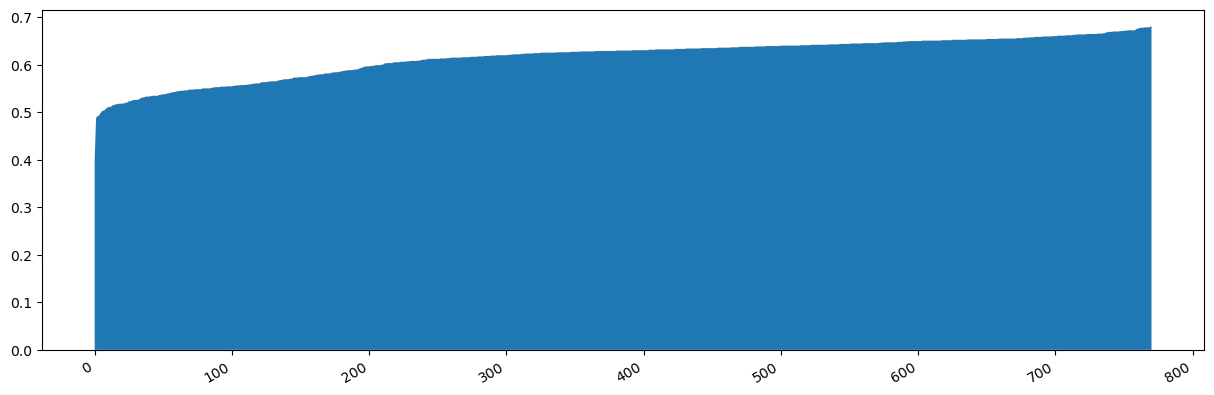

In [ ]:
# Accuracy per feature
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()
ax.stackplot(x, y)

fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
plt.rcParams['figure.figsize'] = [8, 5]

# Prediction per population

In [15]:
geno_np_arr = np.stack(geno_np_layers, axis = -1)

In [ ]:
# Loop through populations in dataset and store genotype reconstruction accuracies
def class_acc_per_pop(model, data, sample_pops):
    pops = []
    class_accs_in_oop = {class_id: [] for class_id in range(data.shape[-1])}
    for cur_pop in np.unique(pop_per_sample):
        pop_idx = sample_pops == cur_pop
        pops.append(cur_pop)
        cur_geno_tensor = data[pop_idx, ...]
        pred = model(cur_geno_tensor)
        true_classes = tf.argmax(cur_geno_tensor[:, 0, ...], axis = -1)
        for class_id in range(pred.shape[-1]):

            class_pred = tf.equal(tf.argmax(pred, axis = -1), class_id)
            class_y = tf.equal(true_classes, class_id)
            correct_pred = tf.cast(tf.logical_and(class_pred, class_y), tf.int32)

            acc = tf.reduce_sum(correct_pred)/tf.reduce_sum(tf.cast(class_y, tf.int32))
            class_accs_in_oop[class_id].append(acc.numpy())    
    res = pd.DataFrame(class_accs_in_oop)
    res["pop"] = pops
    return res

In [ ]:
res_df = class_acc_per_pop(cur_model, geno_np_arr, pop_per_sample)
res_df["data_type"] = "train"
res_df.loc[np.isin(res_df["pop"], test_pops), "data_type"] = "oop"

In [ ]:
eval_df = class_acc_per_pop(cur_model, geno_tensor_eval.numpy(), eval_pops)
eval_df["data_type"] = "eval"

In [54]:
pd.concat([res_df, eval_df]).to_csv("./data/var_autoencoder/with_unseen_children_vanilla_vae/acc_per_pop.csv")